In [1]:
# Familiarity bias (embedding-based)
# - Embedding model: OpenRouter `google/gemini-embedding-001`
# - Score: mean of top-k cosine similarities to train embeddings

import os
import json
import time
import math
import hashlib
import sqlite3
from dataclasses import dataclass
from typing import Iterable, List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import requests

# Reproducibility
np.random.seed(0)

DATA_TRAIN_PATH = "/workspace/Materials_RL/open-materials-guide-2024/data/train-00000-of-00001.parquet"
DATA_TEST_PATH = "/workspace/Materials_RL/open-materials-guide-2024/data/test_high_impact-00000-of-00001.parquet"

KEY_COLS = ["Material_Name", "process", "domain"]
ID_COL = "id"

OPENROUTER_API_KEY_PATH = "/workspace/openrouter_api_key.txt"
OPENROUTER_EMBEDDINGS_URL = "https://openrouter.ai/api/v1/embeddings"
EMBED_MODEL = "google/gemini-embedding-001"

CACHE_DB_PATH = "/workspace/Materials_RL/analysis/embedding_cache.sqlite"  # shared cache file
CACHE_NAMESPACE = EMBED_MODEL

# kNN settings
KNN_K = 10

# Embedding batch settings
BATCH_SIZE = 64
MAX_RETRIES = 6
BASE_BACKOFF_S = 1.0
TIMEOUT_S = 60

print("Paths:")
print("- train:", DATA_TRAIN_PATH)
print("- test :", DATA_TEST_PATH)
print("- cache:", CACHE_DB_PATH)
print("Model:", EMBED_MODEL)
print("KEY_COLS:", KEY_COLS)

Paths:
- train: /workspace/Materials_RL/open-materials-guide-2024/data/train-00000-of-00001.parquet
- test : /workspace/Materials_RL/open-materials-guide-2024/data/test_high_impact-00000-of-00001.parquet
- cache: /workspace/Materials_RL/analysis/embedding_cache.sqlite
Model: google/gemini-embedding-001
KEY_COLS: ['Material_Name', 'process', 'domain']


In [2]:
# 1) Load data
train = pd.read_parquet(DATA_TRAIN_PATH)
test = pd.read_parquet(DATA_TEST_PATH)

print(f"Train: {len(train):,} rows")
print(f"Test : {len(test):,} rows")

missing = [c for c in ([ID_COL] + KEY_COLS) if c not in train.columns]
missing_test = [c for c in ([ID_COL] + KEY_COLS) if c not in test.columns]
print("Missing in train:", missing)
print("Missing in test :", missing_test)

display(train[[ID_COL] + KEY_COLS].head(3))
display(test[[ID_COL] + KEY_COLS].head(3))

Train: 16,026 rows
Test : 169 rows
Missing in train: []
Missing in test : []


,id,Material_Name,process,domain
0,dc948c599976bad88a47b3cd353007a4fa37ca9c,Cerium dioxide nanoparticles (CeO2 NPs),Hybrid,Others
1,035cfeb4113531037c19e8251c43eb6073384404,Epoxy-functional diblock copolymers,Hybrid,Others
2,6e606d85d689a4e63fe51a3008affceb1358079c,Silicon/Zinc oxide heterostructure nanowires,Hybrid,Energy


,id,Material_Name,process,domain
0,b656337f672c936ae90033063bf195a671fdd3d7,Lithium Cobalt Oxide,Pyrolysis,Energy
1,eedccb471a5626725666439865a6c568b977761a,Copper nanoparticles,Hybrid,Energy
2,2e7d916a1c8eba65b1949317efe7f0bdb2f473d6,Copper-silver-zirconium alloy,Vapor Deposition,Healthcare


In [3]:
# 2) Text formatting for embedding

def norm_str(x: object) -> str:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "Unknown"
    s = str(x).strip()
    return s if s else "Unknown"


def make_triplet_text(row: pd.Series) -> str:
    m = norm_str(row[KEY_COLS[0]])
    p = norm_str(row[KEY_COLS[1]])
    d = norm_str(row[KEY_COLS[2]])
    return f"Material: {m}\nProcess: {p}\nDomain: {d}"


train_texts = train.apply(make_triplet_text, axis=1).tolist()
test_texts = test.apply(make_triplet_text, axis=1).tolist()

print("Example text:")
print(train_texts[0])
print("---")
print(test_texts[0])

Example text:
Material: Cerium dioxide nanoparticles (CeO2 NPs)
Process: Hybrid
Domain: Others
---
Material: Lithium Cobalt Oxide
Process: Pyrolysis
Domain: Energy


In [4]:
# 3) OpenRouter embeddings client (google/gemini-embedding-001)

def load_openrouter_api_key(path: str = OPENROUTER_API_KEY_PATH) -> str:
    key = open(path, "r", encoding="utf-8").read().strip()
    if not key:
        raise ValueError(f"Empty OpenRouter API key file: {path}")
    return key


def _sha256(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()


@dataclass
class OpenRouterEmbeddingResult:
    embeddings: np.ndarray  # shape: (n, d), float32


def embed_texts_openrouter(
    texts: List[str],
    *,
    model: str = EMBED_MODEL,
    api_key: Optional[str] = None,
    batch_size: int = BATCH_SIZE,
    max_retries: int = MAX_RETRIES,
    base_backoff_s: float = BASE_BACKOFF_S,
    timeout_s: int = TIMEOUT_S,
    verbose: bool = True,
) -> OpenRouterEmbeddingResult:
    if api_key is None:
        api_key = load_openrouter_api_key()

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
        # Optional but recommended by OpenRouter:
        "HTTP-Referer": "http://localhost",
        "X-Title": "materials-rl-familiarity-embedding",
    }

    all_vecs: List[np.ndarray] = []

    n = len(texts)
    for start in range(0, n, batch_size):
        batch = texts[start : start + batch_size]
        payload = {"model": model, "input": batch}

        attempt = 0
        while True:
            try:
                resp = requests.post(
                    OPENROUTER_EMBEDDINGS_URL,
                    headers=headers,
                    data=json.dumps(payload),
                    timeout=timeout_s,
                )
                if resp.status_code >= 400:
                    raise RuntimeError(f"HTTP {resp.status_code}: {resp.text[:500]}")

                data = resp.json()
                if "data" not in data:
                    raise RuntimeError(f"Unexpected response keys: {list(data.keys())}")

                # OpenAI-style embeddings response: data=[{index, embedding}, ...]
                items = sorted(data["data"], key=lambda x: x.get("index", 0))
                vecs = [np.asarray(it["embedding"], dtype=np.float32) for it in items]
                mat = np.stack(vecs, axis=0)
                all_vecs.append(mat)

                if verbose:
                    print(f"embedded {start + len(batch):,}/{n:,}")
                break

            except Exception as e:
                attempt += 1
                if attempt > max_retries:
                    raise
                sleep_s = base_backoff_s * (2 ** (attempt - 1))
                sleep_s = min(sleep_s, 30.0)
                if verbose:
                    print(f"retry {attempt}/{max_retries} after {sleep_s:.1f}s: {type(e).__name__}: {e}")
                time.sleep(sleep_s)

    emb = np.concatenate(all_vecs, axis=0)
    return OpenRouterEmbeddingResult(embeddings=emb)


# Quick smoke test (1 call, 1 text)
_smoke = embed_texts_openrouter(["hello"], verbose=False)
print("Smoke embedding shape:", _smoke.embeddings.shape)

Smoke embedding shape: (1, 3072)


In [5]:
# 4) Local embedding cache (SQLite)
# - key: sha256(namespace + "\n" + text)
# - vector stored as float32 bytes


def cache_connect(db_path: str = CACHE_DB_PATH) -> sqlite3.Connection:
    conn = sqlite3.connect(db_path)
    conn.execute(
        """
        CREATE TABLE IF NOT EXISTS embeddings (
            namespace TEXT NOT NULL,
            key TEXT NOT NULL,
            text TEXT NOT NULL,
            dim INTEGER NOT NULL,
            vector BLOB NOT NULL,
            created_at REAL NOT NULL,
            PRIMARY KEY(namespace, key)
        );
        """
    )
    conn.execute("CREATE INDEX IF NOT EXISTS idx_embeddings_namespace ON embeddings(namespace);")
    conn.commit()
    return conn


def cache_key(namespace: str, text: str) -> str:
    return _sha256(namespace + "\n" + text)


def cache_get_many(conn: sqlite3.Connection, namespace: str, keys: List[str]) -> Dict[str, np.ndarray]:
    if not keys:
        return {}
    out: Dict[str, np.ndarray] = {}

    # SQLite has a default variable limit; chunk queries.
    CHUNK = 800
    for i in range(0, len(keys), CHUNK):
        sub = keys[i : i + CHUNK]
        placeholders = ",".join(["?"] * len(sub))
        rows = conn.execute(
            f"SELECT key, dim, vector FROM embeddings WHERE namespace = ? AND key IN ({placeholders})",
            [namespace, *sub],
        ).fetchall()
        for k, dim, blob in rows:
            v = np.frombuffer(blob, dtype=np.float32)
            if dim and v.size != dim:
                # tolerate mismatch; still return what we have
                pass
            out[k] = v
    return out


def cache_put_many(conn: sqlite3.Connection, namespace: str, items: List[Tuple[str, str, np.ndarray]]):
    # items: [(key, text, vec)]
    now = time.time()
    rows = []
    for k, text, vec in items:
        vec32 = np.asarray(vec, dtype=np.float32)
        rows.append((namespace, k, text, int(vec32.size), vec32.tobytes(), now))

    conn.executemany(
        "INSERT OR REPLACE INTO embeddings(namespace, key, text, dim, vector, created_at) VALUES (?, ?, ?, ?, ?, ?)",
        rows,
    )
    conn.commit()


def embed_texts_cached(
    texts: List[str],
    *,
    namespace: str = CACHE_NAMESPACE,
    model: str = EMBED_MODEL,
    batch_size: int = BATCH_SIZE,
) -> np.ndarray:
    conn = cache_connect(CACHE_DB_PATH)

    keys = [cache_key(namespace, t) for t in texts]
    cached = cache_get_many(conn, namespace, keys)

    hit = sum(1 for k in keys if k in cached)
    miss_idx = [i for i, k in enumerate(keys) if k not in cached]
    print(f"Cache hit: {hit:,}/{len(keys):,} ({hit/len(keys)*100:.1f}%)")

    # Prepare output buffer (fill cached first)
    out: List[Optional[np.ndarray]] = [None] * len(texts)
    for i, k in enumerate(keys):
        if k in cached:
            out[i] = cached[k]

    if miss_idx:
        miss_texts = [texts[i] for i in miss_idx]
        res = embed_texts_openrouter(miss_texts, model=model, batch_size=batch_size)
        miss_emb = res.embeddings

        # write back to cache
        to_store = []
        for j, i in enumerate(miss_idx):
            k = keys[i]
            vec = miss_emb[j]
            out[i] = vec
            to_store.append((k, texts[i], vec))
        cache_put_many(conn, namespace, to_store)

    mat = np.stack([np.asarray(v, dtype=np.float32) for v in out], axis=0)
    return mat


# Small cache test
_tmp = embed_texts_cached(["hello", "hello", "world"], batch_size=3)
print("cached embedding shape:", _tmp.shape)

Cache hit: 0/3 (0.0%)
embedded 3/3
cached embedding shape: (3, 3072)


In [6]:
# 5) Embed train/test (cached) and compute embedding-based familiarity via kNN cosine

# Compute (or load) embeddings
E_train = embed_texts_cached(train_texts, batch_size=BATCH_SIZE)
E_test = embed_texts_cached(test_texts, batch_size=BATCH_SIZE)

print("E_train:", E_train.shape, E_train.dtype)
print("E_test :", E_test.shape, E_test.dtype)


def l2_normalize(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True)
    return x / (n + eps)


def knn_topk_mean_cosine(
    E_query: np.ndarray,
    E_index: np.ndarray,
    *,
    k: int = KNN_K,
    query_batch: int = 256,
) -> Tuple[np.ndarray, np.ndarray]:
    """Return (scores, topk_indices) where score = mean(top-k cosine sims)."""
    if k <= 0:
        raise ValueError("k must be positive")
    if E_index.shape[0] < k:
        raise ValueError(f"k={k} > index size={E_index.shape[0]}")

    Q = l2_normalize(E_query.astype(np.float32, copy=False))
    X = l2_normalize(E_index.astype(np.float32, copy=False))

    scores = np.empty((Q.shape[0],), dtype=np.float32)
    topk_idx = np.empty((Q.shape[0], k), dtype=np.int32)

    for start in range(0, Q.shape[0], query_batch):
        qb = Q[start : start + query_batch]
        sims = qb @ X.T  # (b, n_index)

        # argpartition for top-k
        idx_part = np.argpartition(-sims, kth=k - 1, axis=1)[:, :k]
        row = np.arange(sims.shape[0])[:, None]
        topk_sims = sims[row, idx_part]

        # sort top-k descending for nicer neighbor display
        order = np.argsort(-topk_sims, axis=1)
        idx_sorted = idx_part[row, order]
        sims_sorted = topk_sims[row, order]

        topk_idx[start : start + sims.shape[0]] = idx_sorted.astype(np.int32)
        scores[start : start + sims.shape[0]] = sims_sorted.mean(axis=1).astype(np.float32)

    return scores, topk_idx


embedding_fam, test_topk_idx = knn_topk_mean_cosine(E_test, E_train, k=KNN_K)
print("embedding_familiarity:")
print("- min/max:", float(embedding_fam.min()), float(embedding_fam.max()))
print("- mean/median:", float(embedding_fam.mean()), float(np.median(embedding_fam)))

Cache hit: 0/16,026 (0.0%)
embedded 64/16,026
embedded 128/16,026
embedded 192/16,026
embedded 256/16,026
embedded 320/16,026
embedded 384/16,026
embedded 448/16,026
embedded 512/16,026
embedded 576/16,026
embedded 640/16,026
embedded 704/16,026
embedded 768/16,026
embedded 832/16,026
embedded 896/16,026
embedded 960/16,026
embedded 1,024/16,026
embedded 1,088/16,026
embedded 1,152/16,026
embedded 1,216/16,026
embedded 1,280/16,026
embedded 1,344/16,026
embedded 1,408/16,026
embedded 1,472/16,026
embedded 1,536/16,026
embedded 1,600/16,026
embedded 1,664/16,026
embedded 1,728/16,026
embedded 1,792/16,026
embedded 1,856/16,026
embedded 1,920/16,026
embedded 1,984/16,026
embedded 2,048/16,026
embedded 2,112/16,026
embedded 2,176/16,026
embedded 2,240/16,026
embedded 2,304/16,026
embedded 2,368/16,026
embedded 2,432/16,026
embedded 2,496/16,026
embedded 2,560/16,026
embedded 2,624/16,026
embedded 2,688/16,026
embedded 2,752/16,026
embedded 2,816/16,026
embedded 2,880/16,026
embedded 2,944

In [7]:
# 6) Rank test samples + show nearest neighbors examples

test_rank = test[[ID_COL] + KEY_COLS].copy()
test_rank["embedding_familiarity"] = embedding_fam

test_rank = test_rank.sort_values("embedding_familiarity", ascending=False).reset_index(drop=True)
display(test_rank.head(10))
display(test_rank.tail(10))

# Robust mapping: test id -> row position (0..n-1) for indexing E_test/test_topk_idx
_test_ids = test[ID_COL].tolist()
_test_id_to_pos = {tid: i for i, tid in enumerate(_test_ids)}


def show_neighbors_for_test_row(test_row_idx_in_sorted: int, *, topk: int = 5):
    row = test_rank.iloc[test_row_idx_in_sorted]
    test_id = row[ID_COL]
    orig_pos = _test_id_to_pos[test_id]

    nn_idx = test_topk_idx[orig_pos][:topk]

    # Compute cosine for display
    q = l2_normalize(E_test[orig_pos : orig_pos + 1])[0]
    Xn = l2_normalize(E_train[nn_idx])
    sims = Xn @ q

    df = train.iloc[nn_idx][[ID_COL] + KEY_COLS].copy()
    df["cosine"] = sims
    df = df.sort_values("cosine", ascending=False)

    print("=" * 80)
    print(f"Test rank #{test_row_idx_in_sorted}  embedding_familiarity={row['embedding_familiarity']:.4f}")
    print(f"id={row[ID_COL]}")
    print(f"Material={row['Material_Name']} | Process={row['process']} | Domain={row['domain']}")
    display(df)


N_SHOW = 3
print("\nTop familiar examples (by embedding):")
for i in range(N_SHOW):
    show_neighbors_for_test_row(i, topk=5)

print("\nBottom unfamiliar examples (by embedding):")
for i in range(N_SHOW):
    show_neighbors_for_test_row(len(test_rank) - 1 - i, topk=5)


,id,Material_Name,process,domain,embedding_familiarity
0,bf59a6f362af0d61270a8fa8a911ae1976255997,Molybdenum disulfide,Vapor Deposition,Electronics,1.000000
1,853b5364f483a041ee32dd8e8b9e38a225aad88d,Graphene,Hybrid,Electronics,1.000000
2,6aaaff321990c4491637263c750a7f91bd22f9b3,Monolayer molybdenum disulfide,Vapor Deposition,Electronics,0.991304
3,7f08f2d04325686e82eca3218c606393ca8ba72f,Methylammonium lead iodide,Hybrid,Energy,0.968359
4,310e8c8c5aeae38f33f77ca5ff3e6994dcc1484b,Magnetite nanoparticles,Hybrid,Environmental,0.955451
5,d90e0bfbd70951dfa86160777ca42b8b5aeefbcf,Zinc oxide,Vapor Deposition,Energy,0.948383
6,1439f978d1a9ed6d2c720f8c806989431bc9171d,Mesoporous silica,Hybrid,Healthcare,0.946476
7,526fae67cbd19dec7b235939369eafcd6618932f,Ti3C2 MXene,Hybrid,Energy,0.944173
8,720a45cbc598adeb985e0659483ceb9b16c97633,Anatase titanium dioxide,Hydrothermal,Energy,0.943681
9,7bc972f2fa1a3259e70f378345333439ef10a2f8,Gel Polymer Electrolytes (GPEs),Solution-Based,Energy,0.943485


,id,Material_Name,process,domain,embedding_familiarity
159,8e6d6e8f336f4c30c5d04d07b4bd7ec857ddae52,Antireflective nanoholes (NH) on glass,Hybrid,Electronics,0.816961
160,c7202870a44f6f02caae729335c5098263d2d7a7,Gallium−Carbon Black−Styrene Isoprene Styrene ...,Mechanochemical,Energy,0.816882
161,6f1149aa1d5a187204db51bf15ca2f8638b850c9,Maleimide-anthracene-functionalized block copo...,Others,Others,0.816498
162,6a79e369c371688560f30066348e0274023deaa3,"Polytetrafluoroethylene (PTFE), Polydimethylsi...",Mechanochemical,Environmental,0.814005
163,c7d0be74337c890612fc5c68903cb70cf30357c8,NUS-119 (and NUS-120),Others,Energy,0.813127
164,b53428cf889e1b71904859e27a3737e1297a5ba4,Poly(thiourea)s (PTUs),Hybrid,Electronics,0.811768
165,36bb8f31be3767c837506365709b01f1ba1f9304,Nickel-based ceramic solid solution nanoshells,Flame aerosol,Energy,0.810619
166,e73fdbdc4507797af8ba2cca4e8ab6cf3b470e05,"Poly[(2,2′-(2,5-dihydroxy-1,4-phenylene)diacet...",Others,Energy,0.805184
167,4c86c5c7351a2166239aa8751127316b836bd1d8,Adaptive Protective Layer (APL),Solution-Based,Energy,0.804420
168,3fb1ba80a55ae164cc31ffcce1c7d343f5d53bb6,PEG-functionalized Rh(II)-based cuboctahedral ...,Melt Quenching,Others,0.785822



Top familiar examples (by embedding):
Test rank #0  embedding_familiarity=1.0000
id=bf59a6f362af0d61270a8fa8a911ae1976255997
Material=Molybdenum disulfide | Process=Vapor Deposition | Domain=Electronics


,id,Material_Name,process,domain,cosine
15750,ffe1d8a3b65c2ef5fac2043c7745f4d54c233f56,Molybdenum disulfide,Vapor Deposition,Electronics,1.0
11643,509c9779115de255e400f8ef683706bb93668416,Molybdenum disulfide,Vapor Deposition,Electronics,1.0
9821,20a76780c5d3fa68dfef191c8404a3402e00aa19,Molybdenum disulfide,Vapor Deposition,Electronics,1.0
5675,eed7848f9f71291fa034c467faf1f0e3fbfff7b7,Molybdenum disulfide,Vapor Deposition,Electronics,1.0
1932,faf4b6281776cd9161f879df5f0ac6bef3f8b471,Molybdenum disulfide,Vapor Deposition,Electronics,1.0


Test rank #1  embedding_familiarity=1.0000
id=853b5364f483a041ee32dd8e8b9e38a225aad88d
Material=Graphene | Process=Hybrid | Domain=Electronics


,id,Material_Name,process,domain,cosine
572,aa118983aa5995a6610fb1290d26f4584534b741,Graphene,Hybrid,Electronics,1.0
12386,59b798c7170c23997c7a7672c085e12914738f22,Graphene,Hybrid,Electronics,1.0
10896,af1a5485b1ea797b685932245bd8eec563e815b7,Graphene,Hybrid,Electronics,1.0
10421,5d493a68187ec1e31e806187a65f8321089e98df,Graphene,Hybrid,Electronics,1.0
2393,546a23b913bd790503c5a3b414c2c25efc952c17,Graphene,Hybrid,Electronics,1.0


Test rank #2  embedding_familiarity=0.9913
id=6aaaff321990c4491637263c750a7f91bd22f9b3
Material=Monolayer molybdenum disulfide | Process=Vapor Deposition | Domain=Electronics


,id,Material_Name,process,domain,cosine
15240,6ebe8692873b2dab7304cf9ef801c58244b2b62b,Monolayer molybdenum disulfide,Vapor Deposition,Electronics,1.000000
13102,6571b3a227928723a45c6f9e4e604189fdf6d603,Molybdenum disulfide monolayer,Vapor Deposition,Electronics,0.994370
1418,ac0efd00b06d2bb8f5d629669cf3bb810d05b588,Monolayer Molybdenum Disulfide,Vapor Deposition,Electronics,0.992362
11931,0e94b40f076e5bc7d3f66c2a48062b6cc7ee061f,Monolayer Molybdenum Disulfide,Vapor Deposition,Electronics,0.992362
10825,23c4bac0ce6ba89c5cb294db97d4f5d5c60a44be,Monolayer Molybdenum Disulfide,Vapor Deposition,Electronics,0.992362



Bottom unfamiliar examples (by embedding):
Test rank #168  embedding_familiarity=0.7858
id=3fb1ba80a55ae164cc31ffcce1c7d343f5d53bb6
Material=PEG-functionalized Rh(II)-based cuboctahedral MOP (BCN-93) | Process=Melt Quenching | Domain=Others


,id,Material_Name,process,domain,cosine
15752,84ff457e89e95d18b492ac8418e5e3bb8ddb3e77,Cu(I) bis(NHC) metal-organic framework (MOF),Hydrothermal,Others,0.794226
11722,f20ceb315d48eb3ceb8d1db33154af75033f6d38,Amorphous metallic glasses,Melt Quenching,Others,0.792815
5582,2470a791d15835f5e8d97227f0a81796ab1d6d04,Microporous Zn-based Metal-Organic Framework,Hydrothermal,Others,0.791688
1357,6f0a93d36a750fea97264465904b3562d0f3af13,HDPE/N-MWNT nanocomposite,Melt Quenching,Others,0.788363
7014,fcbdad42fac567bf3dc2fa17e0637982389d10d8,Porous glass composite,Melt Quenching,Others,0.787851


Test rank #167  embedding_familiarity=0.8044
id=4c86c5c7351a2166239aa8751127316b836bd1d8
Material=Adaptive Protective Layer (APL) | Process=Solution-Based | Domain=Energy


,id,Material_Name,process,domain,cosine
1423,6709664be476a1ed4a7225eeb85a5c9cf671446b,CCPL solid polymer electrolyte,Solution-Based,Energy,0.817199
4934,04092c746a49caecd6312e2a402edd2cba641c2a,Self-healing solid polymer electrolyte,Solution-Based,Energy,0.813407
15436,03839652973c42d94ec4ef939d1572b6dc64d0b5,Acrylic acid derivative terpolymer,Solution-Based,Energy,0.808113
712,473c392b3c4c1ff479167a5f6f63f7d7f0b0fce7,Self-polymerized dopamine,Solution-Based,Energy,0.806501
4878,8b8e5617c52835c097bacbe292a391bab497ff92,Laponite,Solution-Based,Energy,0.805633


Test rank #166  embedding_familiarity=0.8052
id=e73fdbdc4507797af8ba2cca4e8ab6cf3b470e05
Material=Poly[(2,2′-(2,5-dihydroxy-1,4-phenylene)diacetic acid)-stat-3,7-dihydrobenzo[1,2-b:4,5-b′]difuran-2,6-dione] | Process=Others | Domain=Energy


,id,Material_Name,process,domain,cosine
1112,2c8c867ac8d95e1f192bc6cee679750ac577a657,"Poly(1,4-butylene 2,5-furandicarboxylate)-co-p...",Solid-State,Energy,0.817073
1050,06001c7570e8aa5d15f0457ecd381402c42df3e2,Poly-p-diethynylbenzene,Hybrid,Energy,0.811213
9501,7089112c817c1322630c815c0ae6d3531ddf6e5b,Amino-Acid-Substituted Perylene Diimide,Others,Energy,0.810897
1509,58cb33773deb8596ff414b954fc64b69d734652a,Poly(imides) containing benzimidazole,Others,Energy,0.810620
15763,935d115f8657a925408ec9362b619e307a7d5e8c,Polypyrene,Others,Energy,0.802916


/opt/conda/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/py311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


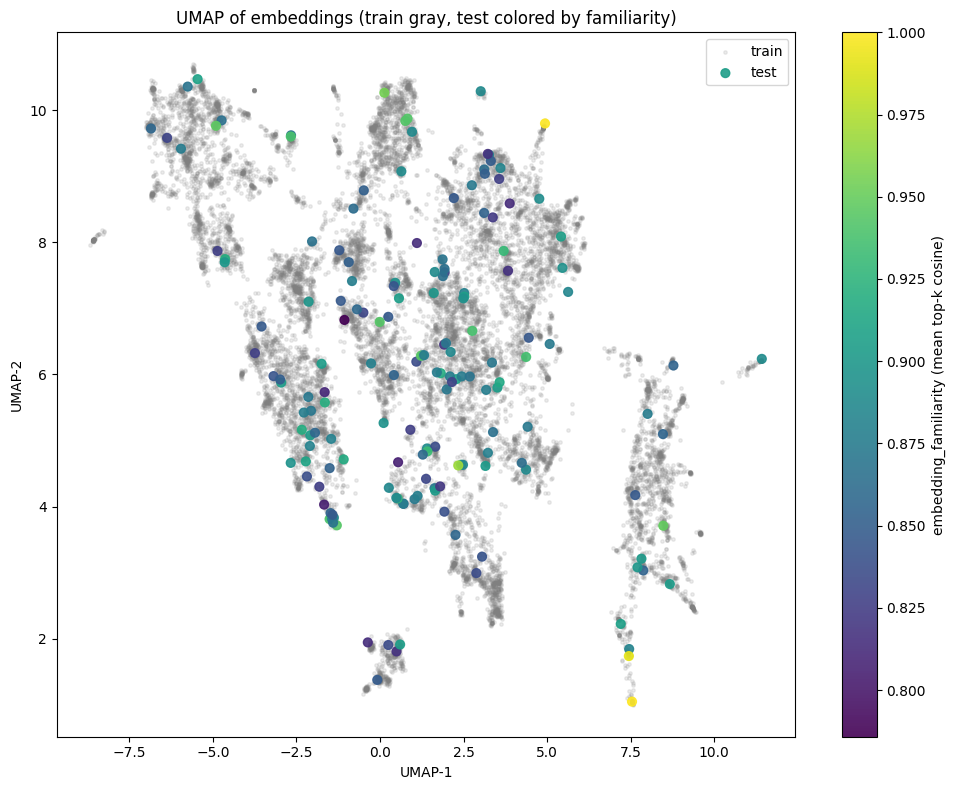

In [8]:
# 7) UMAP 2D visualization (train vs test)

import matplotlib.pyplot as plt

try:
    import umap
except Exception as e:
    raise ImportError(
        "umap-learn is required. Install with: pip install umap-learn\n"
        f"Original import error: {e}"
    )

# Use normalized embeddings for cosine geometry
E_all = np.vstack([E_train, E_test]).astype(np.float32, copy=False)
E_all_n = l2_normalize(E_all)

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=0,
)
XY = reducer.fit_transform(E_all_n)

XY_train = XY[: len(E_train)]
XY_test = XY[len(E_train) :]

plt.figure(figsize=(10, 8))
plt.scatter(XY_train[:, 0], XY_train[:, 1], s=6, alpha=0.15, c="gray", label="train")
sc = plt.scatter(
    XY_test[:, 0],
    XY_test[:, 1],
    s=40,
    alpha=0.9,
    c=embedding_fam,
    cmap="viridis",
    label="test",
)
plt.colorbar(sc, label="embedding_familiarity (mean top-k cosine)")
plt.title("UMAP of embeddings (train gray, test colored by familiarity)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.tight_layout()
plt.show()